<a href="https://colab.research.google.com/github/davidemichelon11/NLU/blob/main/NLU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
import numpy as np
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity

nltk.download('punkt')
nltk.download('vader_lexicon' )
nltk.download('subjectivity')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm

In [4]:
import spacy
spacy.cli.download('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
def doc2string(doc):
  return " ".join([w for sent in doc for w in sent])

def sent2string(sent):
  return " ".join([w for w in sent])

In [6]:
nltk.download('stopwords')

import unicodedata
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

stop_words = stopwords.words("english")

def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
  )

def normalizeString(s):
  text_tokens = word_tokenize(s)
  s = [word for word in text_tokens if not word in stop_words and not word in punctuation]
  s = unicodeToAscii(sent2string(s).lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')]

corpus_sub = [normalizeString(sent2string(d[0])) for d in subj_docs] + [normalizeString(sent2string(d[0])) for d in obj_docs]

labels_sub = np.array(['subj'] * len(subj_docs) + ['obj'] * len(obj_docs))
train_samples_sub, test_samples_sub, train_labels_sub, test_labels_sub = train_test_split(corpus_sub, labels_sub, test_size=0.3)


**Baselines for subjectivity/objectivity detection**

Model: *Support Vector Machine*

In [8]:
# SVM for subj/obj detection
classifier_SVM_subj = svm.SVC()
vectorizer_sub = CountVectorizer()

vectors = vectorizer_sub.fit_transform(train_samples_sub + test_samples_sub)

#SVM
classifier_SVM_subj.fit(vectors[:len(train_samples_sub)], train_labels_sub)
labels_pred_SVM = classifier_SVM_subj.predict(vectors[len(train_labels_sub):])
print(classification_report(test_labels_sub, labels_pred_SVM, digits=3))

              precision    recall  f1-score   support

         obj      0.851     0.901     0.875      1479
        subj      0.898     0.846     0.871      1521

    accuracy                          0.873      3000
   macro avg      0.874     0.874     0.873      3000
weighted avg      0.875     0.873     0.873      3000



**Baselines for Seniment Analysis**

1.   *SVM with objective sentences*
2.   *SVM without objective sentences*
3.   *Using VADER on complete review*
4.   *Using VADER analyze each sentence*




In [9]:
nltk.download('movie_reviews')
mr = movie_reviews
neg = mr.paras(categories='neg')
pos = mr.paras(categories='pos')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [10]:
vectorizer_sa = CountVectorizer()
classifier_sa = svm.SVC()

#each element is the review converted to string
corpus_sa = [normalizeString(doc2string(p)) for p in pos] + [normalizeString(doc2string(n)) for n in neg]

labels_sa = np.array([0] * len(pos) + [1] * len(neg))
train_samples_sa, test_samples_sa, train_labels_sa, test_labels_sa = train_test_split(corpus_sa, labels_sa, test_size=0.1)

In [11]:
#SVM with objective sentences
vectors = vectorizer_sa.fit_transform(train_samples_sa + test_samples_sa)
classifier_sa.fit(vectors[:len(train_samples_sa)], train_labels_sa)
labels_pred = classifier_sa.predict(vectors[len(train_labels_sa):])

print(classification_report(test_labels_sa, labels_pred, digits=3))

              precision    recall  f1-score   support

           0      0.859     0.833     0.846       102
           1      0.832     0.857     0.844        98

    accuracy                          0.845       200
   macro avg      0.845     0.845     0.845       200
weighted avg      0.845     0.845     0.845       200



In [12]:
def remove_obj_sentences(reviews, vectorizer_sub):
  new_list = []
  for rev in reviews:
    new_rev = []
    for s in rev:
      vector = vectorizer_sub.transform([sent2string(s)]).toarray()
      if classifier_SVM_subj.predict(vector) == ['subj']: 
        new_rev.append(s)
    new_list.append(new_rev)
  return new_list

In [13]:
# For each review, remove obj sentences and compute the SVM
vectorizer_sa_subj = CountVectorizer()
classifier_SVM_subj_2 = svm.SVC()

new_pos = remove_obj_sentences(pos, vectorizer_sub)
new_neg = remove_obj_sentences(neg, vectorizer_sub)

corpus_sa_subj = [normalizeString(doc2string(p)) for p in new_pos] + [normalizeString(doc2string(n)) for n in new_neg]

labels_sa_subj = np.array([0] * len(new_pos) + [1] * len(new_neg))
train_samples_, test_samples_, train_labels_, test_labels_ = train_test_split(corpus_sa_subj, labels_sa_subj, test_size=0.2)

vectors_ = vectorizer_sa_subj.fit_transform(train_samples_ + test_samples_)
classifier_SVM_subj_2.fit(vectors_[:len(train_samples_)], train_labels_)
labels_pred_ = classifier_SVM_subj_2.predict(vectors_[len(train_labels_):])

print(classification_report(test_labels_, labels_pred_, digits=3))

              precision    recall  f1-score   support

           0      0.817     0.846     0.831       201
           1      0.839     0.809     0.824       199

    accuracy                          0.828       400
   macro avg      0.828     0.827     0.827       400
weighted avg      0.828     0.828     0.827       400



**VADER Baseline**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

In [ ]:
# Analyse complete review
analyzer = SentimentIntensityAnalyzer()
labels_vader = np.array([0] * len(neg) + [1] * len(pos))
prediction_val = [analyzer.polarity_scores(doc2string(v)) for v in (pos + neg)]
prediction_labels = [0 if p['pos'] > p['neg'] else 1 for p in prediction_val]

print(classification_report(labels_sa, prediction_labels, digits=3))

              precision    recall  f1-score   support

           0      0.583     0.842     0.689      1000
           1      0.715     0.397     0.511      1000

    accuracy                          0.620      2000
   macro avg      0.649     0.619     0.600      2000
weighted avg      0.649     0.620     0.600      2000



In [ ]:
# Analyse each sentence of review, sum sentences contribution as 1
prediction_labels = []

for rev in (pos+neg):
  pos_ = 0
  neg_ = 0
  for sent in rev:
    p = analyzer.polarity_scores(" ".join([w for w in sent]))
    if p['pos'] > p['neg']: pos_ += 1
    else: neg_ += 1
  prediction_labels.append(0 if pos_ > neg_ else 1)
print(classification_report(labels_sa, prediction_labels, digits=3))

prediction_labels = []

for rev in (pos+neg):
  pos_ = 0
  neg_ = 0
  for sent in rev:
    p = analyzer.polarity_scores(" ".join([w for w in sent]))
    if p['pos'] > p['neg']: pos_ += p['pos']
    else: neg_ += p['neg']
  prediction_labels.append(0 if pos_ > neg_ else 1)
print(classification_report(labels_sa, prediction_labels, digits=3))

              precision    recall  f1-score   support

           0      0.698     0.500     0.583      1000
           1      0.611     0.784     0.687      1000

    accuracy                          0.642      2000
   macro avg      0.654     0.642     0.635      2000
weighted avg      0.654     0.642     0.635      2000

              precision    recall  f1-score   support

           0      0.602     0.843     0.702      1000
           1      0.738     0.442     0.553      1000

    accuracy                          0.642      2000
   macro avg      0.670     0.642     0.628      2000
weighted avg      0.670     0.642     0.628      2000



**Objectivity detection using LSTM**

In [14]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [15]:
batch_size = 120
seq_len = 100
word_embedding = 300
epochs = 10
learning_rate = 0.01
n_categories = 2
n_hidden = 256
lr = 3e-4

In [ ]:
class Db(data.Dataset):
  def __init__(self, rev, labels):
    self.rev = rev
    self.labels = labels

  def __len__(self):
    return len(self.rev)

  def __getitem__(self, idx: int):
    return torch.tensor(self.rev[idx]), torch.tensor(self.labels[idx])

In [ ]:
def get_scheduler(optimizer, epochs, sched='cosine'):
  if sched == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
  
  return scheduler

def get_optimizer(model, lr, wd=0, momentum=0, opt='Adam'):
  if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif opt == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  
  return optimizer

In [ ]:
def create_tens(rev, seq_len, word_embedding):
  
  rev = word_tokenize(rev)
  if len(rev) > seq_len: 
    rev = rev[:seq_len]

  sent = []
  for i, w in enumerate(rev):
    vector = nlp.vocab[w].vector
    sent.append(vector.tolist())
  
  z = list(np.zeros(word_embedding, dtype=np.float32))
  zs = [z for each in range(seq_len - len(sent))]
  return zs + sent

In [ ]:
labels = np.append(np.zeros((len(subj_docs)), dtype=int), np.ones((len(subj_docs)), dtype=int))

train_samples, test_samples, train_labels, test_labels = train_test_split(corpus_sub, labels, test_size=0.3)

train_samples = [create_tens(rev, seq_len, word_embedding) for rev in train_samples]
test_samples = [create_tens(rev, seq_len, word_embedding) for rev in test_samples]

# train samples are tensors of seq_len x word_embedding
train_dataset = Db(train_samples, train_labels)
test_dataset = Db(test_samples, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# training
def train(model, optimizer, train_loader, e):

  cumulative_accuracy = 0
  samples=0
  pbar = tqdm(train_loader)
  for x,y in pbar:
    x = x.to(device)
    y = y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y.long())
    _, predicted = outputs.max(1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    samples += x.shape[0]
    cumulative_accuracy += predicted.eq(y).sum().item()
    pbar.set_description('Epoch {}/{}, Train accuracy: {:.2f}'.format(e+1,epochs, cumulative_accuracy/samples*100))
  return cumulative_accuracy/samples*100

In [ ]:
def evaluate(model, test_loader):

  cumulative_accuracy = 0
  samples=0
  pbar = tqdm(test_loader)
  for x,y in pbar:
    x = x.to(device)
    y = y.to(device)

    outputs = model(x)
    loss = criterion(outputs, y.long())
    _, predicted = outputs.max(1)
    samples += x.shape[0]
    cumulative_accuracy += predicted.eq(y).sum().item()
    pbar.set_description('Evaluate accuracy: {:.2f}'.format(cumulative_accuracy/samples*100))
  return cumulative_accuracy/samples*100

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.i2h = nn.LSTM(input_size, hidden_size, num_layers=2, dropout = 0.5, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.leaky_ReLU = nn.LeakyReLU(0.1)
    self.i2o = nn.Linear(2*hidden_size, output_size)
      
  def forward(self, input, hidden=None, cell=None):
    if hidden==None:
      hidden = self.init_hidden(input.shape[0])
    if cell==None:
      cell = self.init_hidden(input.shape[0])

    output, (_,_)= self.i2h(input, (hidden,cell))
    output = self.dropout(output)
    output = self.i2o(output)
    output = self.leaky_ReLU(output)
    output = output[:, -1]
    return output

  def init_hidden(self,shape=1):
    return torch.zeros(2*2, shape, self.hidden_size).to(device)
    
  def init_cell(self,shape=1):
    return torch.zeros(2, shape, self.hidden_size).to(device)

In [ ]:
# !wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
# !chmod +x mini.sh
# !bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
# !python -m ipykernel install --name "py39" --user

In [ ]:
lstm = LSTM(word_embedding, n_hidden, n_categories).to(device)
optimizer = get_optimizer(lstm, lr)
scheduler = get_scheduler(optimizer, epochs)

for e in range(epochs):
  train(lstm, optimizer, train_loader, e)
  scheduler.step()
evaluate(lstm, test_loader)

Evaluate accuracy: 90.67: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


90.66666666666666

**Importing pre-trained DistilBERT model and tokenizer**

**Fine-tune BERT Model for Sentiment Analysis in Google Colab**


In [ ]:
! pip3 install transformers

In [17]:
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import transformers as ppb
from sklearn.linear_model import LogisticRegression

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [18]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [19]:
BATCH_SIZE = 16
MAX_LEN = 512

In [20]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    #returns the last hidden state (_) and the pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [21]:
from google.colab import output
output.disable_custom_widget_manager()

In [22]:
def  create_data_loader(reviews, targets, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=reviews,
    targets=targets,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(ds,batch_size=batch_size,num_workers=2)
  
corpus_sa_subj = [normalizeString(doc2string(p)) for p in pos] + [normalizeString(doc2string(n)) for n in neg]

train_data, test_data, train_labels, test_labels = train_test_split(corpus_sa_subj, labels_sa_subj)

train_data_loader = create_data_loader(train_data, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
categories = 2
model = SentimentClassifier(categories).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * epochs

#As in the paper: the lr decreases linearly from the initial lr set in the optimizer to 0
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    # thanks to dataloader, data are aggregated
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    # to avoid exploding gradient
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device,n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0


  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )
  print('Train loss {:.3f} Train accuracy {:.3f} '.format(train_loss, train_acc))

  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_data)
  )
  print('Test loss {:.3f} Test accuracy {:.3f} '.format(test_loss, test_acc))

  print('-' * 10)
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

Epoch 1/10
Train loss 0.690 Train accuracy 0.526 
Test loss 0.540 Test accuracy 0.720 
----------
Epoch 2/10
Train loss 0.431 Train accuracy 0.815 
Test loss 0.354 Test accuracy 0.868 
----------
Epoch 3/10
Train loss 0.238 Train accuracy 0.924 
Test loss 0.554 Test accuracy 0.862 
----------
Epoch 4/10
Train loss 0.173 Train accuracy 0.951 
Test loss 0.638 Test accuracy 0.870 
----------
Epoch 5/10
Train loss 0.105 Train accuracy 0.975 
Test loss 0.639 Test accuracy 0.876 
----------
Epoch 6/10
Train loss 0.082 Train accuracy 0.980 
Test loss 0.702 Test accuracy 0.870 
----------
Epoch 7/10
Train loss 0.029 Train accuracy 0.994 
Test loss 0.788 Test accuracy 0.870 
----------
Epoch 8/10
Train loss 0.023 Train accuracy 0.995 
Test loss 0.773 Test accuracy 0.880 
----------
Epoch 9/10
Train loss 0.011 Train accuracy 0.997 
Test loss 0.770 Test accuracy 0.872 
----------
Epoch 10/10
Train loss 0.002 Train accuracy 0.999 
Test loss 0.795 Test accuracy 0.882 
----------


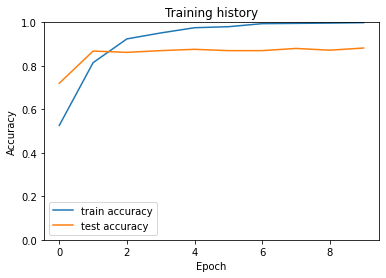

In [28]:
import matplotlib.pyplot as plt

plt.plot([s.item() for s in history['train_acc']], label='train accuracy')
plt.plot([s.item() for s in history['test_acc']], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);